# Redes Convolucionales

Keras nos permite crear redes convolucionales para procesar imágenes usando la capa `keras.layers.Conv2D`. Los parámetros para estas capas serán los que estudiamos para capas convlucionales (cantidad de kernels, tamaño de cada kernel, stride, tipo de padding, etc.). Podemos mezclarla también con capas de pooling como `keras.layers.MaxPool2D` y  las capas densas que ya hemos visto.

Comenzamos importando las librerías iniciales y mostrando algunos ejemplos.

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [2]:
(imgs_train, labs_train), (imgs_test, labs_test) = keras.datasets.cifar10.load_data()
print(imgs_train.shape)
print(imgs_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [3]:
nombres = ['avión', 'auto', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

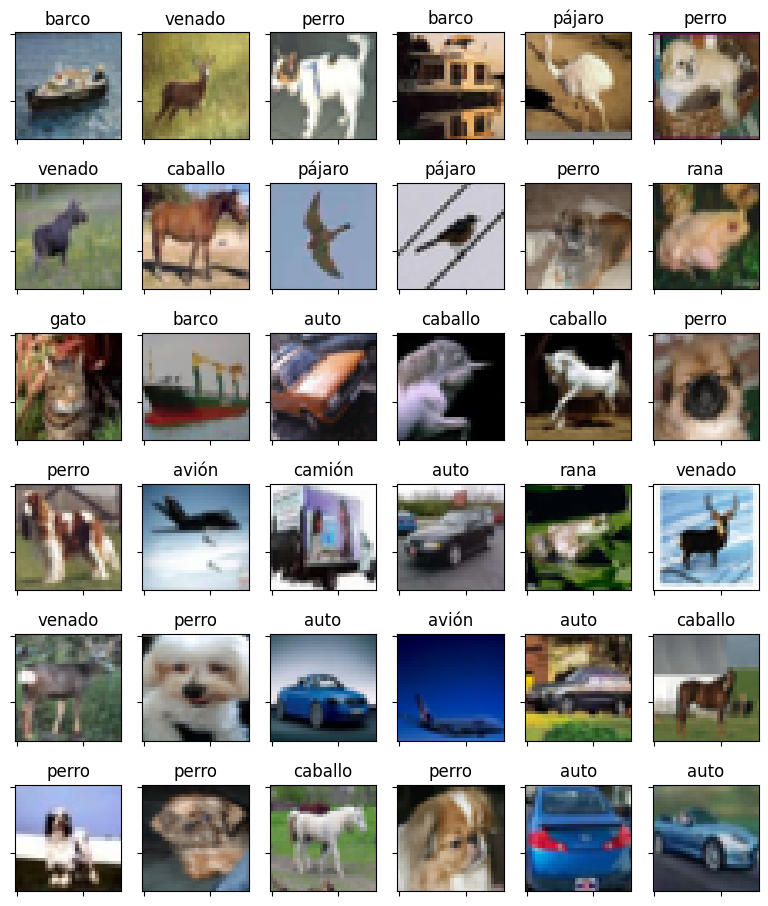

In [5]:
# Mostramos una grilla de ejemplos (al azar) del conjunto de test

h = 6 # alto de la grilla
w = 6 # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*w,1.9*h))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(len(imgs_test))
    axs[i,j].set_title(nombres[labs_test[ex][0]])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(imgs_test[ex])

In [8]:
# Normalizamos los datos de imagenes pero no cambiamos la forma

X_train = imgs_train
X_train = X_train / 255

X_test = imgs_test
X_test = X_test / 255

print(X_train.shape, X_test.shape)

# Las etiquetas si debemos llevarlas a un vector one-hot

Y_train = keras.utils.to_categorical(labs_train, 10)
Y_test = keras.utils.to_categorical(labs_test, 10)

print(Y_train.shape, Y_test.shape)
print(Y_train[0])


(50000, 32, 32, 3) (10000, 32, 32, 3)
[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]
(50000, 10) (10000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Importando capas

Ahora comenzaremos a usar más tipos de capas distintas por lo que será conveniente importarlas para no tener que anteponer `keras.layers` cada vez que las usemos. Las capas que usaremos inicialmente serán `Dense`, `Conv2D`, `MaxPool2D` y `Flatten` (esta última se usa para cambiar la forma de los datos de manera de que puedan ser entregados a una red feed-forward).

In [9]:
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten

##  Nuestra primera red convolucional

El siguiente código  crea una red con la siguiente arquitectura

**Convolucional 64 (3x3) --> Max Pooling (2x2) --> Densa 128 (relu) --> Densa 10 **

Las capas se agregan igual que para redes feed-forward. Hay un par de cosas que sería bueno que notes:

- Nota el parámetro `input_shape` de la primera capa. Es similar al `input_dim` de la primera capa densa, pero ahora la forma de la entrada es un tensor que representa a la imagen con su forma habitual `(32,32,3)` es decir, imágenes de 32x32 pixeles y 3 canales de color.
- Nota que hemos usado la capa `Flatten` entre la capa de max pooling y la capa densa. Esto es para cambiar la forma de los tensores que fluyen por la red.

Mira el resumen de la arquitectura de la red y asegúrate que entiendes la forma de la salida de cada capa (es importante entenderlo pues te servirá después para encontrar posibles errores en el código y en el entrenamiento).

In [10]:
# Creamos una red neuronal convolucional simple

red_conv = keras.Sequential()

red_conv.add(Conv2D(64, (3,3), input_shape=(32,32,3), activation='relu'))
red_conv.add(MaxPool2D((2,2)))
red_conv.add(Flatten())
red_conv.add(Dense(128, activation='relu'))
red_conv.add(Dense(10, activation='softmax'))

red_conv.summary()

/Users/oxfist/.pyenv/versions/3.12.2/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,843,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,846,410 (7.04 MB)

 Trainable params: 1,846,410 (7.04 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenando

Ahora entrenamos por 25 épocas.

In [11]:
np.random.seed(30)
tf.random.set_seed(30)

red_conv.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

hist = red_conv.fit(
    X_train,Y_train,
    batch_size=64,
    epochs=25,
    validation_data=(X_test,Y_test)
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2460 - loss: 2.1078 - val_accuracy: 0.3396 - val_loss: 1.8514
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3923 - loss: 1.7428 - val_accuracy: 0.3996 - val_loss: 1.6619
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.4560 - loss: 1.5596 - val_accuracy: 0.4552 - val_loss: 1.4938
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5005 - loss: 1.4257 - val_accuracy: 0.4970 - val_loss: 1.3950
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5323 - loss: 1.3338 - val_accuracy: 0.5164 - val_loss: 1.3433
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5540 - loss: 1.2700 - val_accuracy: 0.5277 - val_loss: 1.3129
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5724 - loss: 1.2210 - val_accuracy: 0.5430 - val_loss: 1.2822
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5891 - loss: 1.1801 - 

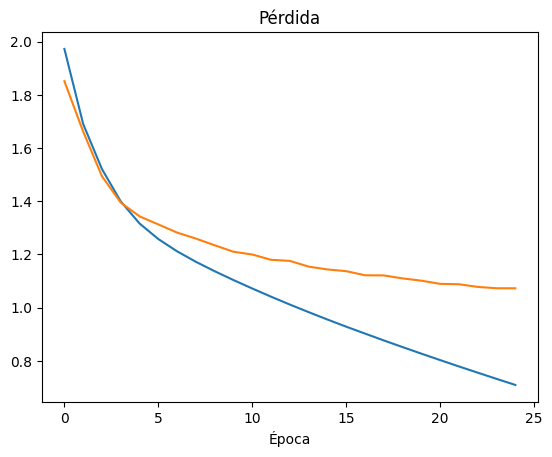

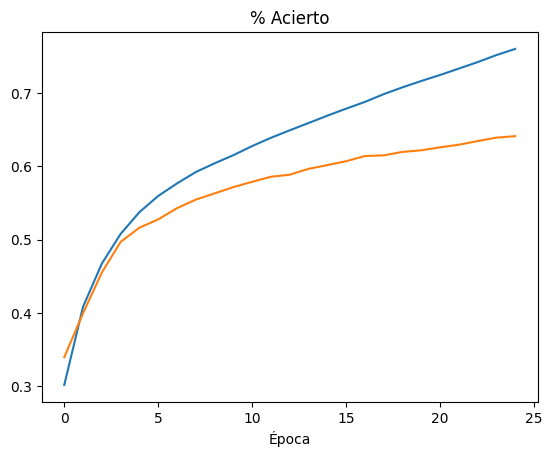

In [12]:
# Mostramos la pérdida y el acierto por cada época

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

## Ejercicio: Mejorando el acierto con más capas

La red anterior aunque muy simple, alcanzó un acierto de sobre 60% en unas pocas épocas lo que está muy por encima de la red feed-forward del laboratorio pasado. Lo otro que es fácil notar, si graficaste la pérdida y el acierto, es que la red tiene un sobreajuste (overfitting) considerable,  por lo que sería bueno no solo agregar capas si no también agregar regularización.

Ahora crearás una red convolucional de 3 capas convolucionales y dos capas densas para mejorar la predicción y además agregarás capas de dropout intermedias. Tu red debe tener esta arquitectura

**Convolucional 32 (3x3) -->  Convolucional 32 (3x3) -->  Max Pooling (2x2) --> Convolucional 64 (3x3) --> Max Pooling (2x2) --> Densa 512 -->  Densa 10**

Considera todas las activaciones como `relu`. Si hiciste todo bien, tu red debiera tener alrededor de **1,2M parámetros**. Nota que  es bastante menos que para la red anterior incluso cuando la anterior tenía menos capas (¿puedes explicar por qué?).

Debes realizar lo siguiente:
- Entrena primero con la arquitectura de arriba sin regularización. Hazlo solo por 30 épocas.
- Imprime la pérdida y el acierto por cada época y nota que mejora el acierto, pero que hay  un alto sobreajuste.
- Posteriormente agrega algunas capas de dropout, dos o tres con una tasa de dropout moderada (0.2 a 0.3), y entrena otra vez por 40 épocas
- Imprime la pérdida y el acierto por cada época y asegúrate que mejora el acierto y baja el sobre ajuste. Haz los cambios que estimes convenientes para mejorar las métricas.

En el último paso deberías llegar al menos a un 70% de acierto en el conjunto de prueba (si no lo alcanzas, intenta haciendo cambios como hemos aprendido en clases).  Opcionalmente muestra algunos ejemplos de las predicciones de tu red y guarda el modelo para usarlo posteriormente.


### a) Crea la arquitectura

Crea la arquitectura con 3 capas convolucionales y dos densas, imprime el resumen de la red y entrénala por 30 épocas.

In [13]:
# Acá empieza tu código para crear la red (~10 líneas de código)
red_conv = keras.Sequential()

red_conv.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
red_conv.add(Conv2D(32, (3,3), activation='relu'))
red_conv.add(MaxPool2D((2,2)))
red_conv.add(Conv2D(64, (3,3), activation='relu'))
red_conv.add(MaxPool2D((2,2)))
red_conv.add(Flatten())
red_conv.add(Dense(512, activation='relu'))
red_conv.add(Dense(10, activation='softmax'))

red_conv.summary()


# Acá termina tu código

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,930 (4.63 MB)

 Trainable params: 1,213,930 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
np.random.seed(30)
tf.random.set_seed(30)

# Acá tu código para compilar y entrenar la red

red_conv.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

hist = red_conv.fit(
    X_train,Y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_test,Y_test)
)
# Acá termina tu código.

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.2020 - loss: 2.1626 - val_accuracy: 0.2942 - val_loss: 1.9452
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.3603 - loss: 1.8088 - val_accuracy: 0.3510 - val_loss: 1.7911
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - accuracy: 0.4372 - loss: 1.5845 - val_accuracy: 0.4574 - val_loss: 1.5163
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.4909 - loss: 1.4364 - val_accuracy: 0.4927 - val_loss: 1.4324
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5269 - loss: 1.3407 - val_accuracy: 0.5095 - val_loss: 1.4002
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 28ms/step - accuracy: 0.5537 - loss: 1.2673 - val_accuracy: 0.5318 - val_loss: 1.3413
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.5758 - loss: 1.2036 - val_accuracy: 0.5468 - val_loss: 1.2993
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.5977 - loss: 1.1444 - 

### b) Imprime los resultados

Muestra un gráfico con la pérdida y el acierto por época de entrenamiento. El acierto debiera mejorar tanto en el conjunto de entrenamiento como en el de prueba, pero también debiera notarse un sobreajuste considerable.

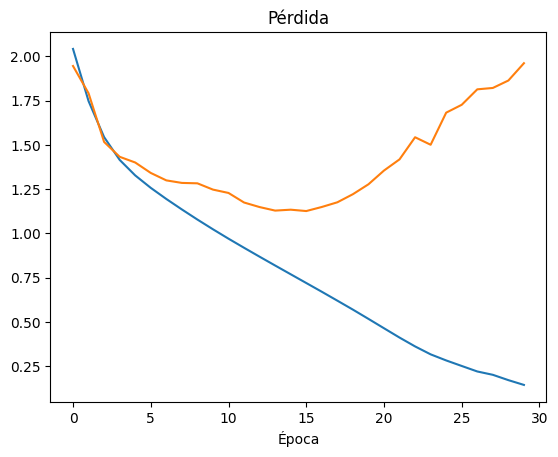

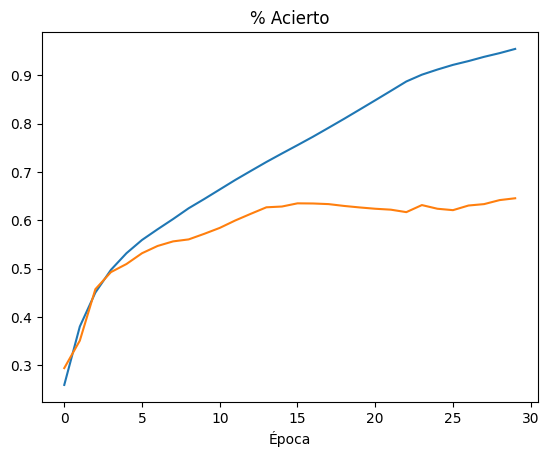

In [15]:
# Acá tu código para mostrar pérdida y acierto

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

# Acá termina tu código

### c) Agrega dropoup

Agrega un par (al menos dos) capas de dropout con probabilidad moderada (0.2 a 0.3), reentrena por 30-40 épocas.



In [16]:
# Acá tu código para la nueva red con dropout

red_conv = keras.Sequential()

red_conv.add(Conv2D(32, (3,3), input_shape=(32,32,3), activation='relu'))
red_conv.add(Conv2D(32, (3,3), activation='relu'))
red_conv.add(MaxPool2D((2,2)))
red_conv.add(Conv2D(64, (3,3), activation='relu'))
red_conv.add(Dropout(0.3))
red_conv.add(MaxPool2D((2,2)))
red_conv.add(Flatten())
red_conv.add(Dense(512, activation='relu'))
red_conv.add(Dropout(0.3))
red_conv.add(Dense(10, activation='softmax'))

red_conv.summary()

# Acá termina tu código

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,213,930 (4.63 MB)

 Trainable params: 1,213,930 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
np.random.seed(30)
tf.random.set_seed(30)

# Acá tu código para compilar y entrenar la red

red_conv.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

hist = red_conv.fit(
    X_train,Y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_test,Y_test)
)

# Acá termina tu codigo

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.1881 - loss: 2.1791 - val_accuracy: 0.2983 - val_loss: 1.9769
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.3514 - loss: 1.8222 - val_accuracy: 0.3698 - val_loss: 1.7773
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4260 - loss: 1.5992 - val_accuracy: 0.4696 - val_loss: 1.5264
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - accuracy: 0.4771 - loss: 1.4609 - val_accuracy: 0.5037 - val_loss: 1.4336
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5152 - loss: 1.3700 - val_accuracy: 0.5312 - val_loss: 1.3658
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5389 - loss: 1.3016 - val_accuracy: 0.5313 - val_loss: 1.3516
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5652 - loss: 1.2420 - val_accuracy: 0.5661 - val_loss: 1.2622
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.5827 - loss: 1.1826 - 

### d) Analiza los resultados y repite si fuera necesario

Imprime las curvas de aprendizaje y asegúrate de que no hay un sobre ajuste considerable y que el acierto en el conjunto de prueba es al menos 70%. Si es necesario, repite la parte (e)  haciendo los cambios que estimes conveniente (como agregar otra capa de dropout o  aumentar la probabilidad de dropout si es que aun hay mucho sobreajuste).

In [ ]:
# Acá tu código para mostrar pérdida y acierto

red_conv.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

hist = red_conv.fit(
    X_train,Y_train,
    batch_size=64,
    epochs=30,
    validation_data=(X_test,Y_test)
)

# Acá termina tu código

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

### e) Opcional: ejemplos de predicciones

Muestra ejemplos al azar de las predicciones de tu modelo con los ejemplos de prueba.

In [ ]:
# Acá tu código para mostrar algunas predicciones



# Acá termina tu código